In [1]:
from ecnet.datasets import load_mon, QSPRDataset
from sklearn.model_selection import train_test_split

smiles, targets = load_mon()
smiles_train, smiles_test, targets_train, targets_test = train_test_split(
    smiles, targets, test_size=0.2, random_state=24
)
dataset_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
dataset_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)

torch.Size([246, 5305]) torch.Size([62, 5305])


In [2]:
from ecnet.tasks.feature_selection import select_rfr

desc_idx, desc_imp = select_rfr(dataset_train, total_importance=1.0,
                                n_estimators=50, n_jobs=8)

In [3]:
"""
Main iteration: for i=0 -> n_samples in training set, evaluate:
    - NN trained with `i` most-important descriptors from Random Forest Regression
    - NN trained with `i` principal components
    
10 NNs are trained at each `i` to measure accuracy and variance; TODO: increase this?
"""

from sklearn.metrics import median_absolute_error, r2_score
from sklearn.decomposition import PCA
from ecnet import ECNet
from copy import deepcopy
import torch

train_mae_rfr = []
train_mae_pca = []
train_r2_rfr = []
train_r2_pca = []

test_mae_rfr = []
test_mae_pca = []
test_r2_rfr = []
test_r2_pca = []

# Evaluate every 8 additional input values
for n_inp in range(0, dataset_train.desc_vals.shape[0] - 1, 8):
    
    print('Inp: {}/{}'.format(n_inp + 1, dataset_train.desc_vals.shape[0]))
    
    # RANDOM FOREST REGRESSION #
    
    _rfr_train = deepcopy(dataset_train)
    _rfr_test = deepcopy(dataset_test)
    _rfr_train.set_desc_index(desc_idx[:n_inp + 1])
    _rfr_test.set_desc_index(desc_idx[:n_inp + 1])

    _tr_mae = []
    _tr_r2 = []
    _te_mae = []
    _te_r2 = []
    
    # Train each `n_inp` case 10 times
    for _ in range(10):
    
        _model = ECNet(_rfr_train.desc_vals.shape[1], 1, 128,
                       _rfr_train.target_vals.shape[1])
        # random_state = None, shuffles training/validation subsets each train
        _model.fit(dataset=_rfr_train, valid_size=0.2, patience=64, epochs=512,
                   random_state=None, lr=0.01, lr_decay=1e-6, batch_size=32)
        y_hat_train = _model(_rfr_train.desc_vals).detach().numpy()
        y_hat_test = _model(_rfr_test.desc_vals).detach().numpy()
        y_train = _rfr_train.target_vals.detach().numpy()
        y_test = _rfr_test.target_vals.detach().numpy()
        _tr_mae.append(median_absolute_error(y_hat_train, y_train))
        _tr_r2.append(r2_score(y_hat_train, y_train))
        _te_mae.append(median_absolute_error(y_hat_test, y_test))
        _te_r2.append(r2_score(y_hat_test, y_test))
        
    train_mae_rfr.append(_tr_mae)
    train_r2_rfr.append(_tr_r2)
    test_mae_rfr.append(_te_mae)
    test_r2_rfr.append(_te_r2)
    
    # PRINCIPAL COMPONENT ANALYSIS #
    
    _pca_train = deepcopy(dataset_train)
    _pca_test = deepcopy(dataset_test)
    
    pca = PCA(n_components=n_inp + 1, svd_solver='full')
    pca.fit(_pca_train.desc_vals.detach().numpy())
    _pca_train.desc_vals = torch.from_numpy(pca.transform(
        _pca_train.desc_vals.detach().numpy()
    ))
    _pca_test.desc_vals = torch.from_numpy(pca.transform(
        _pca_test.desc_vals.detach().numpy()
    ))
    
    _tr_mae = []
    _tr_r2 = []
    _te_mae = []
    _te_r2 = []
    
    # Train each `n_inp` case 10 times
    for _ in range(10):
        
        _model = ECNet(_pca_train.desc_vals.shape[1], 1, 128,
                       _pca_train.target_vals.shape[1])
        _model.fit(dataset=_pca_train, valid_size=0.2, patience=64, epochs=512,
                   random_state=None, lr=0.01, lr_decay=1e-6, batch_size=32)
        y_hat_train = _model(_pca_train.desc_vals).detach().numpy()
        y_hat_test = _model(_pca_test.desc_vals).detach().numpy()
        y_train = _rfr_train.target_vals.detach().numpy()
        y_test = _rfr_test.target_vals.detach().numpy()
        _tr_mae.append(median_absolute_error(y_hat_train, y_train))
        _tr_r2.append(r2_score(y_hat_train, y_train))
        _te_mae.append(median_absolute_error(y_hat_test, y_test))
        _te_r2.append(r2_score(y_hat_test, y_test))
        
    train_mae_pca.append(_tr_mae)
    train_r2_pca.append(_tr_r2)
    test_mae_pca.append(_te_mae)
    test_r2_pca.append(_te_r2)
    
    # END ITER #

Inp: 1/246
Inp: 9/246
Inp: 17/246
Inp: 25/246
Inp: 33/246
Inp: 41/246
Inp: 49/246
Inp: 57/246
Inp: 65/246
Inp: 73/246
Inp: 81/246
Inp: 89/246
Inp: 97/246
Inp: 105/246
Inp: 113/246
Inp: 121/246
Inp: 129/246
Inp: 137/246
Inp: 145/246
Inp: 153/246
Inp: 161/246
Inp: 169/246
Inp: 177/246
Inp: 185/246
Inp: 193/246
Inp: 201/246
Inp: 209/246
Inp: 217/246
Inp: 225/246
Inp: 233/246
Inp: 241/246


In [7]:
import numpy as np

tr_mae_rfr_std = [np.std(mae) for mae in train_mae_rfr]
tr_r2_rfr_std = [np.std(r2) for r2 in train_r2_rfr]
te_mae_rfr_std = [np.std(mae) for mae in test_mae_rfr]
te_r2_rfr_std = [np.std(r2) for r2 in test_r2_rfr]

tr_mae_pca_std = [np.std(mae) for mae in train_mae_pca]
tr_r2_pca_std = [np.std(r2) for r2 in train_r2_pca]
te_mae_pca_std = [np.std(mae) for mae in test_mae_pca]
te_r2_pca_std = [np.std(r2) for r2 in test_r2_pca]

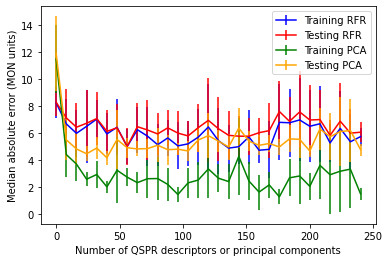

In [13]:
from matplotlib import pyplot as plt

n_inp = [i * 8 for i in range(len(train_mae_rfr))]

plt.clf()
plt.xlabel('Number of QSPR descriptors or principal components')
plt.ylabel('Median absolute error (MON units)')
plt.errorbar(n_inp, [np.mean(mae) for mae in train_mae_rfr], yerr=tr_mae_rfr_std, color='blue', label='Training RFR')
plt.errorbar(n_inp, [np.mean(mae) for mae in test_mae_rfr], yerr=te_mae_rfr_std, color='red', label='Testing RFR')
plt.errorbar(n_inp, [np.mean(mae) for mae in train_mae_pca], yerr=tr_mae_pca_std, color='green', label='Training PCA')
plt.errorbar(n_inp, [np.mean(mae) for mae in test_mae_pca], yerr=te_mae_pca_std, color='orange', label='Testing PCA')
plt.legend(loc='upper right')
plt.show()

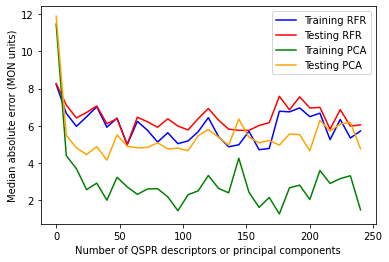

In [14]:
plt.clf()
plt.xlabel('Number of QSPR descriptors or principal components')
plt.ylabel('Median absolute error (MON units)')
plt.errorbar(n_inp, [np.mean(mae) for mae in train_mae_rfr], color='blue', label='Training RFR')
plt.errorbar(n_inp, [np.mean(mae) for mae in test_mae_rfr], color='red', label='Testing RFR')
plt.errorbar(n_inp, [np.mean(mae) for mae in train_mae_pca], color='green', label='Training PCA')
plt.errorbar(n_inp, [np.mean(mae) for mae in test_mae_pca], color='orange', label='Testing PCA')
plt.legend(loc='upper right')
plt.show()

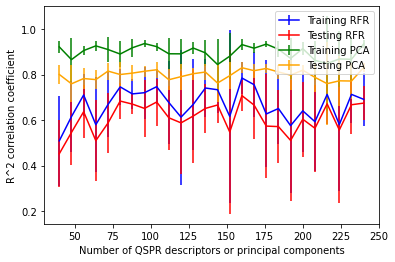

In [17]:
plt.clf()
plt.xlabel('Number of QSPR descriptors or principal components')
plt.ylabel('R^2 correlation coefficient')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in train_r2_rfr][5:], yerr=tr_r2_rfr_std[5:], color='blue', label='Training RFR')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in test_r2_rfr][5:], yerr=te_r2_rfr_std[5:], color='red', label='Testing RFR')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in train_r2_pca][5:], yerr=tr_r2_pca_std[5:], color='green', label='Training PCA')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in test_r2_pca][5:], yerr=te_r2_pca_std[5:], color='orange', label='Testing PCA')
plt.legend(loc='upper right')
plt.show()

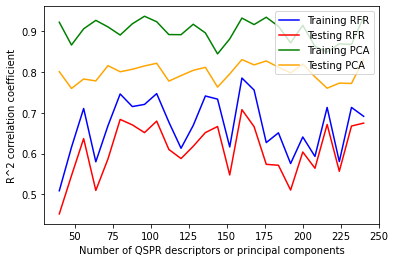

In [18]:
plt.clf()
plt.xlabel('Number of QSPR descriptors or principal components')
plt.ylabel('R^2 correlation coefficient')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in train_r2_rfr][5:], color='blue', label='Training RFR')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in test_r2_rfr][5:], color='red', label='Testing RFR')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in train_r2_pca][5:], color='green', label='Training PCA')
plt.errorbar(n_inp[5:], [np.mean(r2) for r2 in test_r2_pca][5:], color='orange', label='Testing PCA')
plt.legend(loc='upper right')
plt.show()

In [24]:
print('Lowest Train MAE, RFR: {}'.format(min([np.mean(mae) for mae in train_mae_rfr])))
print('Lowest Train MAE, PCA: {}'.format(min([np.mean(mae) for mae in train_mae_pca])))
print('Lowest Test MAE, RFR: {}'.format(min([np.mean(mae) for mae in test_mae_rfr])))
print('Lowest Test MAE, PCA: {}'.format(min([np.mean(mae) for mae in test_mae_pca])))
print('Highest Train R2, RFR: {}'.format(max([np.mean(r2) for r2 in train_r2_rfr])))
print('Highest Train R2, PCA: {}'.format(max([np.mean(r2) for r2 in train_r2_pca])))
print('Highest Test R2, RFR: {}'.format(max([np.mean(r2) for r2 in test_r2_rfr])))
print('Highest Test R2, PCA: {}'.format(max([np.mean(r2) for r2 in test_r2_pca])))

Lowest Train MAE, RFR: 4.7178497314453125
Lowest Train MAE, PCA: 1.2672498226165771
Lowest Test MAE, RFR: 4.996086120605469
Lowest Test MAE, PCA: 4.159858226776123
Highest Train R2, RFR: 0.7848706828505299
Highest Train R2, PCA: 0.9361727327918261
Highest Test R2, RFR: 0.7075411390579762
Highest Test R2, PCA: 0.830786126435979
